# Bayesian Belief Network - Lung cancer

### Biblioteki

Dane dotyczące raka płuc zostały pobrane z https://www.kaggle.com/mysarahmadbhat/lung-cancer

In [1]:
!pip install pybbn
!pip install kaggle

  Created wheel for pybbn: filename=pybbn-3.2.1-py3-none-any.whl size=39726 sha256=1108310efc05e0cf49cdb7385c2e3cf3a5b0e69038f6d494bc6bee6d95d0885b
  Stored in directory: /root/.cache/pip/wheels/a8/64/55/b52530d41fe7c9ae501ddd7c06f3122ceb5f15921680f0371b
Successfully built pybbn


In [2]:
import pandas as pd # for data manipulation 
import networkx as nx # for drawing graphs
import matplotlib.pyplot as plt # for drawing graphs

# for creating Bayesian Belief Networks (BBN)
from pybbn.graph.dag import Bbn
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController
from pybbn.graph.potential import Potential

import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import numpy as np

### Zbiór danych Lung Cancer

In [5]:
pd.options.display.max_columns=50
df=pd.read_csv('lung_cancer.csv', encoding='utf-8')

df['AGE']=df['AGE'].apply(lambda x: 2 if x>65 else 1)
df['GENDER']=df['GENDER'].apply(lambda x: 2 if x == 'M' else 1)
df['LUNG_CANCER']=df['LUNG_CANCER'].apply(lambda x: 2 if x == 'YES' else 1)
health = df[df['LUNG_CANCER'] == 1]
sick = df[df['LUNG_CANCER'] == 2]

df = pd.concat([health, sick], axis=0)
df = df.sample(frac=1)

In [6]:
test_count = 40
df_train = df.iloc[:-test_count-1,:]
df_test = df.iloc[-test_count:,:]
df_test

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
181,1,2,2,2,2,2,1,2,1,2,1,2,2,2,1,2
253,1,2,2,2,2,2,1,2,1,2,1,2,2,2,1,2
280,1,1,2,1,1,1,2,2,2,1,1,1,2,1,1,1
151,2,1,1,1,1,2,1,2,2,2,2,1,1,2,1,2
60,2,2,1,2,1,2,2,2,2,2,2,2,1,2,2,2
127,2,1,2,2,2,2,2,1,1,1,2,1,1,2,2,2
87,2,1,1,2,2,1,1,2,1,2,1,1,1,2,2,2
167,2,1,1,1,1,1,2,1,2,1,2,2,2,2,2,2
121,2,1,1,1,1,1,2,2,2,2,2,2,2,1,2,2
149,2,1,2,1,1,1,1,1,2,2,2,2,1,1,2,2


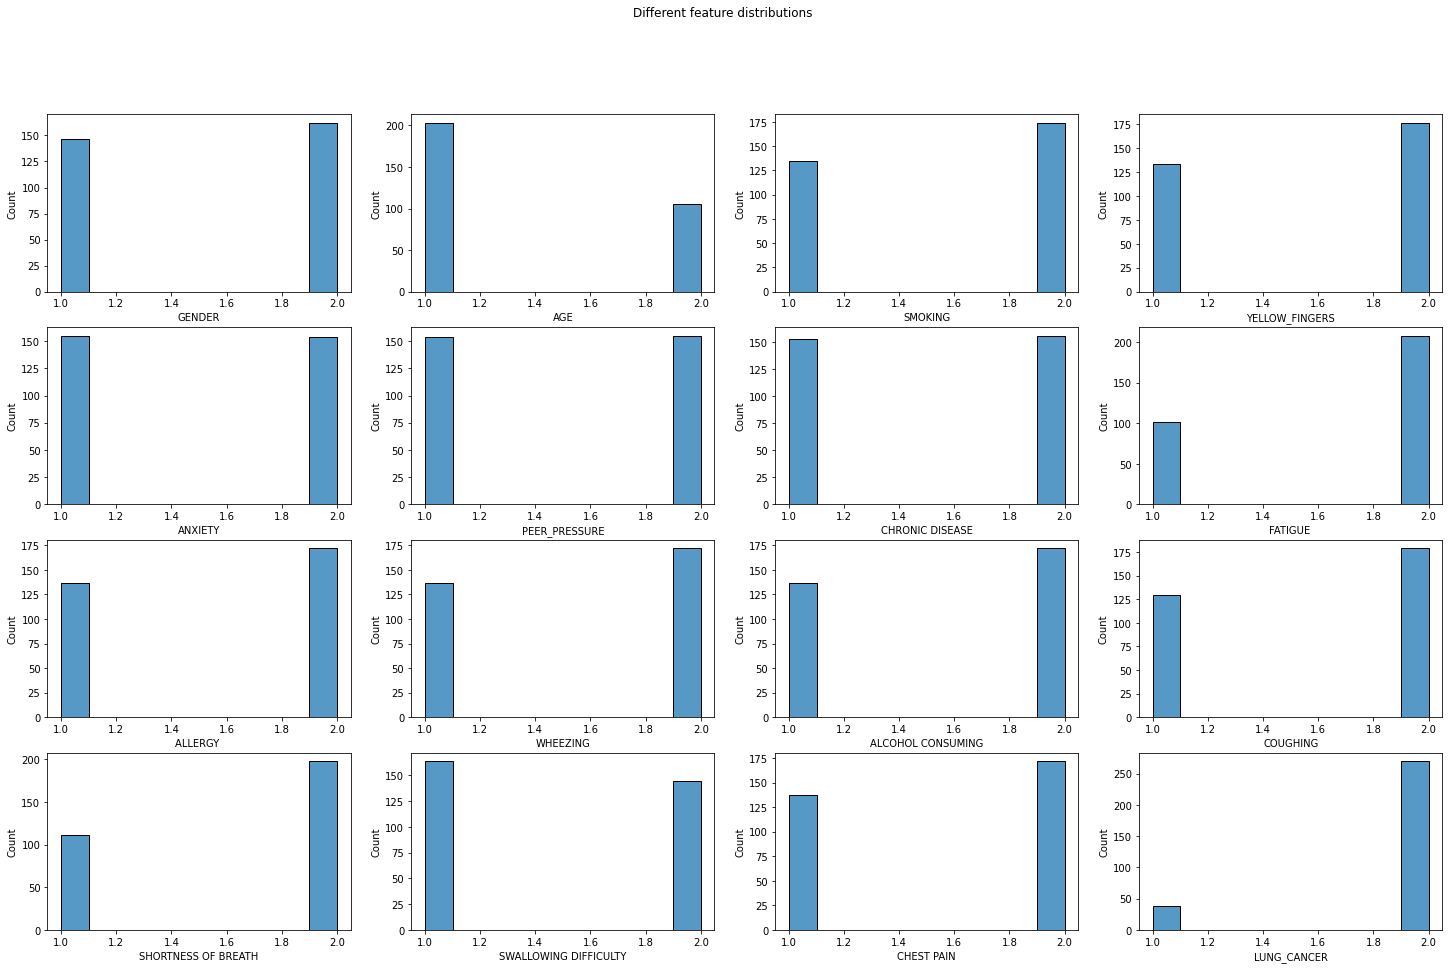

In [7]:
fig, axes = plt.subplots(4, 4, figsize=(25, 15))
fig.suptitle('Different feature distributions')

axes = axes.reshape(16,)

for i,column in enumerate(df.columns):
    sns.histplot(ax = axes[i],data = df, x= column)

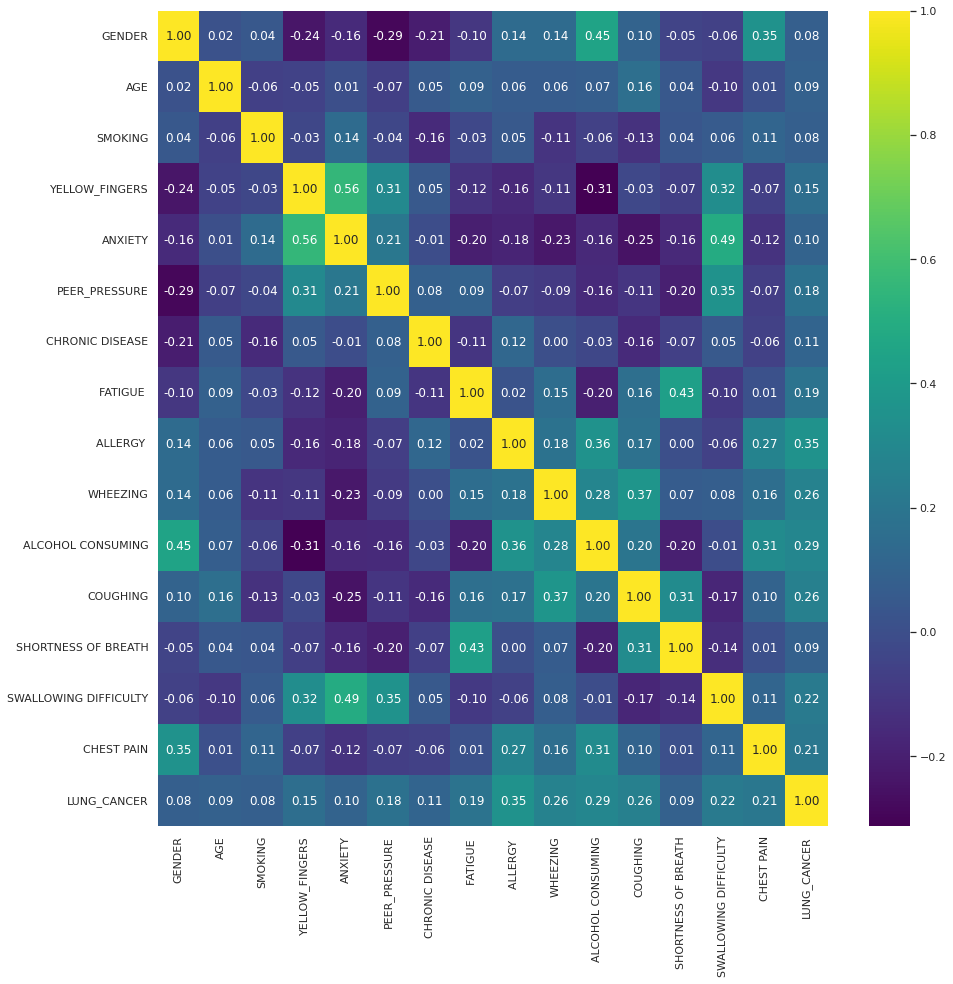

In [66]:
list1 = ["GENDER", "AGE", "SMOKING","YELLOW_FINGERS","ANXIETY","PEER_PRESSURE", "CHRONIC DISEASE","FATIGUE ", "ALLERGY ", "WHEEZING", "ALCOHOL CONSUMING", "COUGHING", "SHORTNESS OF BREATH", "SWALLOWING DIFFICULTY", "CHEST PAIN", "LUNG_CANCER"]
sns.heatmap(df_train[list1].corr(), cmap = "viridis", annot = True, fmt = ".2f")
sns.set(rc = {'figure.figsize':(10,10)})
plt.show()

### BBN

In [87]:
def probs(data, child, parents=None):
    if parents==None or len(parents) == 0:
        # Calculate probabilities
        prob=pd.crosstab(data[child], 'Empty', margins=False, normalize='columns').sort_index().to_numpy().reshape(-1).tolist()
    else:
      prob=pd.crosstab([data[parent] for parent in parents],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
      print(prob)
    return prob  

In [102]:
def create_node(idx, p1=None, p2=None):
    name = df.columns[idx]
    parents = []
    if p1 != None:
      parents.append(df.columns[p1])
    if p2 != None:
      parents.append(df.columns[p2])
    prob =  probs(df_train, child=name, parents=parents)
    return BbnNode(Variable(idx, name, [1, 2]), prob)

def create_node_from_list(idx, ps): 
    name = df.columns[idx]
    parents = [df.columns[p] for p in ps]
    prob =  probs(df_train, child=name, parents=parents)
    return BbnNode(Variable(idx, name, [1, 2]), prob)


nodes = [
    create_node(0),
    create_node(1),
    create_node(2),
    create_node(3),
    create_node(4),
    create_node(5),
    create_node(6),
    create_node(7),
    create_node(8, 0, 1),
    create_node(9, 2, 3),
    create_node(10, 4, 5),
    create_node(11, 6, 7),
    create_node(12, 8, 9),
    create_node(13, 10, 11),
    create_node(14, 12, 13),
    create_node(15, 14)
]

edges = [
    Edge(nodes[0], nodes[8], EdgeType.DIRECTED),
    Edge(nodes[1], nodes[8], EdgeType.DIRECTED),
    Edge(nodes[2], nodes[9], EdgeType.DIRECTED),
    Edge(nodes[3], nodes[9], EdgeType.DIRECTED),
    Edge(nodes[4], nodes[10], EdgeType.DIRECTED),
    Edge(nodes[5], nodes[10], EdgeType.DIRECTED),
    Edge(nodes[6], nodes[11], EdgeType.DIRECTED),
    Edge(nodes[7], nodes[11], EdgeType.DIRECTED),
    Edge(nodes[8], nodes[12], EdgeType.DIRECTED),
    Edge(nodes[9], nodes[12], EdgeType.DIRECTED),
    Edge(nodes[10], nodes[13], EdgeType.DIRECTED),
    Edge(nodes[11], nodes[13], EdgeType.DIRECTED),
    Edge(nodes[12], nodes[14], EdgeType.DIRECTED),
    Edge(nodes[13], nodes[14], EdgeType.DIRECTED),
    Edge(nodes[14], nodes[15], EdgeType.DIRECTED)
]

# nodes = [
#     create_node(0),
#     create_node(1),
#     create_node(2),
#     create_node(3),
#     create_node(4),
#     create_node(5),
#     create_node(6),
#     create_node(7),
#     create_node(8),
#     create_node(9),
#     create_node(10),
#     create_node(11),
#     create_node(12),
#     create_node(13),
#     create_node(14),
#     create_node_from_list(15, range(0, 16))
# ]

# edges = [Edge(nodes[i], nodes[15], EdgeType.DIRECTED) for i in range(0, 16)]

# pos = {0: (-3.5, 4),
#        1: (-2.5, 4),
#        2: (-1.5, 4),
#        3: (-0.5, 4),
#        4: (0.5, 4),
#        5: (1.5, 4),
#        6: (2.5, 4),
#        7: (3.5, 4),
#        8: (-3, 3),
#        9: (-1, 3),
#        10: (1, 3),
#        11: (3, 3),
#        12: (-1.5, 2),
#        13: (1.5, 2),
#        14: (0, 1),
#        15: (0, 0)}


def create_network(nodes, edges):
    bbn = Bbn()
    for node in nodes:
        bbn.add_node(node)
    for edge in edges:
        bbn.add_edge(edge)
    return bbn

bbn = create_network(nodes, edges)      

[0.5113636363636364, 0.48863636363636365, 0.4883720930232558, 0.5116279069767442, 0.4, 0.6, 0.2978723404255319, 0.7021276595744681]
[0.4888888888888889, 0.5111111111111111, 0.3235294117647059, 0.6764705882352942, 0.3283582089552239, 0.6716417910447762, 0.6363636363636364, 0.36363636363636365]
[0.38271604938271603, 0.6172839506172839, 0.35294117647058826, 0.6470588235294118, 0.36363636363636365, 0.6363636363636364, 0.6419753086419753, 0.35802469135802467]
[0.4, 0.6, 0.3404255319148936, 0.6595744680851063, 0.6538461538461539, 0.34615384615384615, 0.42528735632183906, 0.5747126436781609]
[0.49230769230769234, 0.5076923076923077, 0.17647058823529413, 0.8235294117647058, 0.2631578947368421, 0.7368421052631579, 0.4, 0.6]
[0.5757575757575758, 0.42424242424242425, 0.4909090909090909, 0.509090909090909, 0.27450980392156865, 0.7254901960784313, 0.6875, 0.3125]
[0.7380952380952381, 0.2619047619047619, 0.21153846153846154, 0.7884615384615384, 0.3883495145631068, 0.6116504854368932, 0.5070422535211

In [103]:
# Convert the BBN to a join tree
join_tree = InferenceController.apply(bbn)

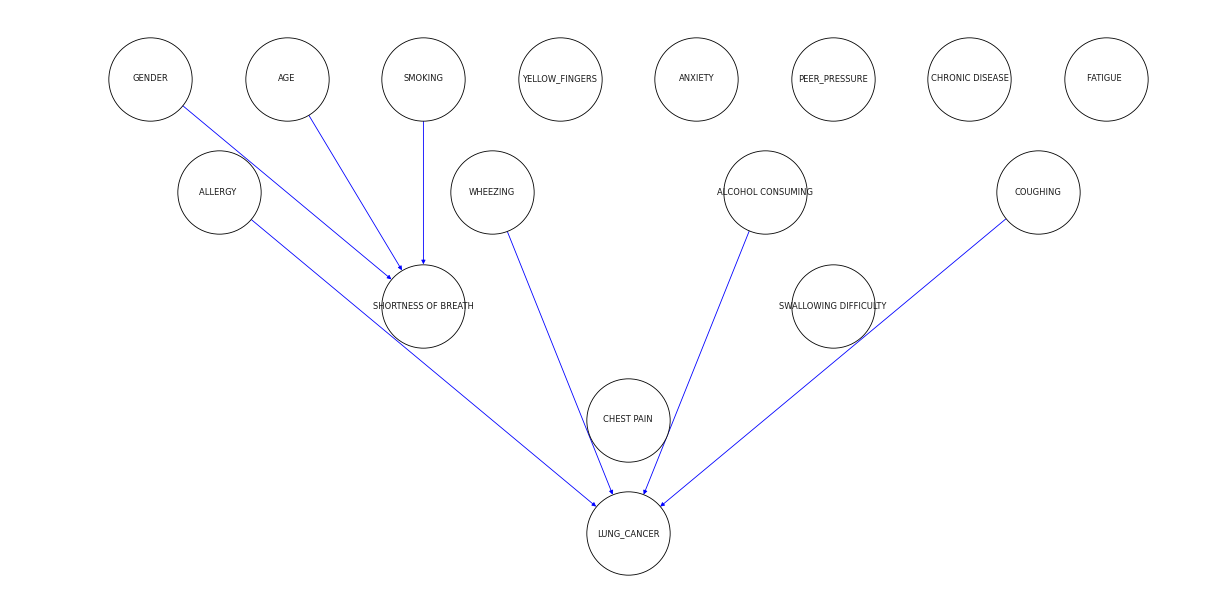

In [80]:
# Set options for graph looks
options = {
    "font_size": 10,
    "node_size": 10000,
    "node_color": "white",
    "edgecolors": "black",
    "edge_color": "blue",
    "linewidths": 1,
    "width": 1,}
    
# Generate graph
plt.figure(1, figsize=(20, 10), dpi=60)
n, d = bbn.to_nx_graph()
nx.draw(n, with_labels=True, labels=d, pos=pos, **options)

# Update margins and print the graph
ax = plt.gca()
ax.margins(0.10)
plt.axis("off")
plt.show()

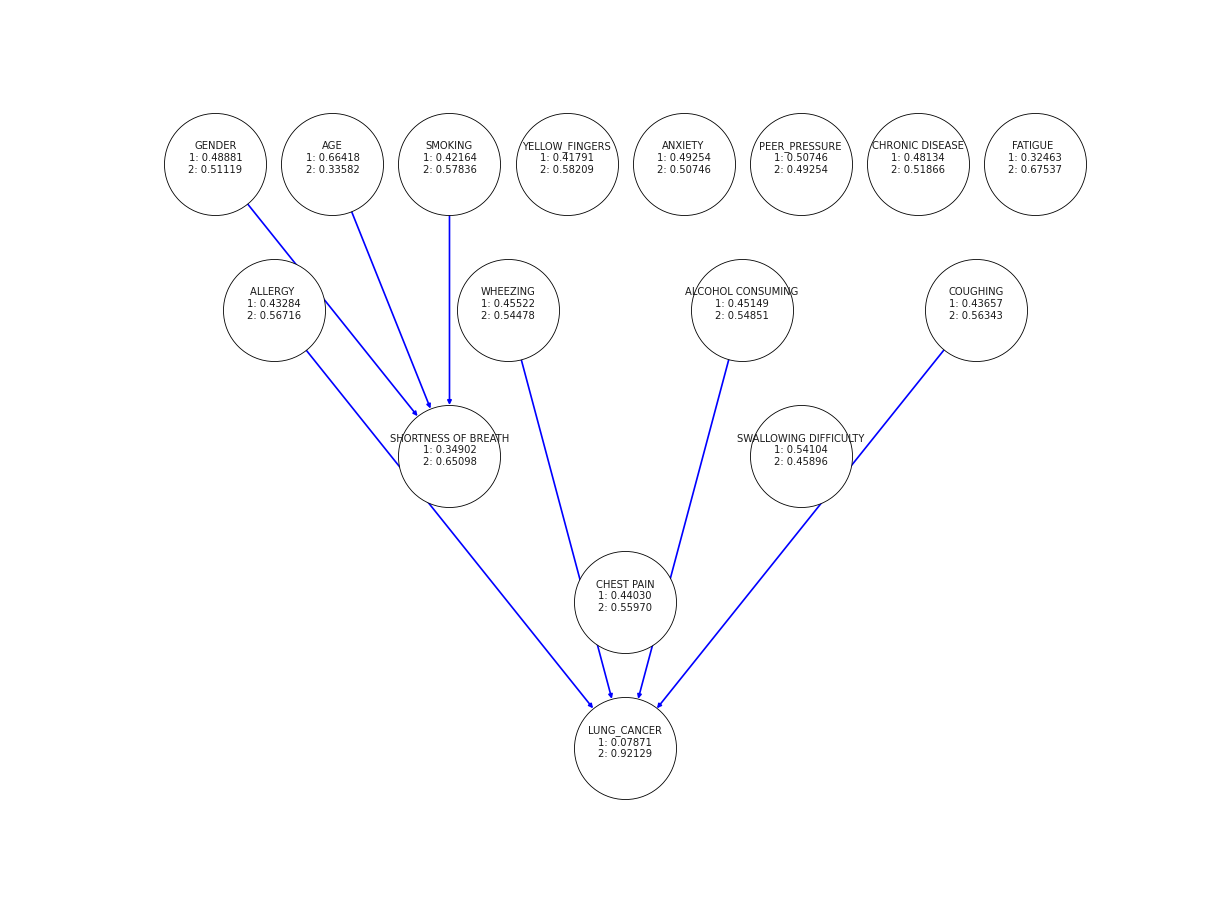

In [81]:
# Define a function for printing marginal probabilities
def print_probs(jt):
    for node in jt.get_bbn_nodes():
        potential = jt.get_bbn_potential(node)
        print("Node:", "dupa")
        print("Values:")
        print(potential)
        print('----------------')

def node_to_text(node, potential):
  node_dict = node.to_dict()
  potential_dict = list(Potential.to_dict([potential]).values())
  text = node_dict['variable']['name'] + "\n"

  for i in range(len(node_dict['variable']['values'])):
    text += f"{node_dict['variable']['values'][i]}: {potential_dict[i]:.5f}\n"
  return text

def draw_graph_probs(jt):
  d_new = { idx : df.columns[idx] for idx in range(len(df.columns)) }
  options2 = {
      "font_size": 12,
      "node_size": 15000,
      "node_color": "white",
      "edgecolors": "black",
      "edge_color": "blue",
      "linewidths": 1,
      "width": 2,
      "node_shape": "o",}
  plt.figure(1, figsize=(20, 15), dpi=60)
  for node in jt.get_bbn_nodes():
    node_dict = node.to_dict()
    potential = jt.get_bbn_potential(node)
    d_new[node_dict['variable']['id']] = node_to_text(node, potential)

  nx.draw(n, labels=d_new, with_labels=True, pos=pos, **options2)
  ax = plt.gca()
  ax.margins(0.20)
  plt.axis("off")
  plt.show()

# Use the above function to print marginal probabilities
# print_probs(join_tree)
draw_graph_probs(join_tree)

In [82]:
# To add evidence of events that happened so probability distribution can be recalculated
def evidence(jt, nod, cat, val):
    ev = EvidenceBuilder() \
    .with_node(jt.get_bbn_node_by_name(nod)) \
    .with_evidence(cat, val) \
    .build()
    jt.set_observation(ev)

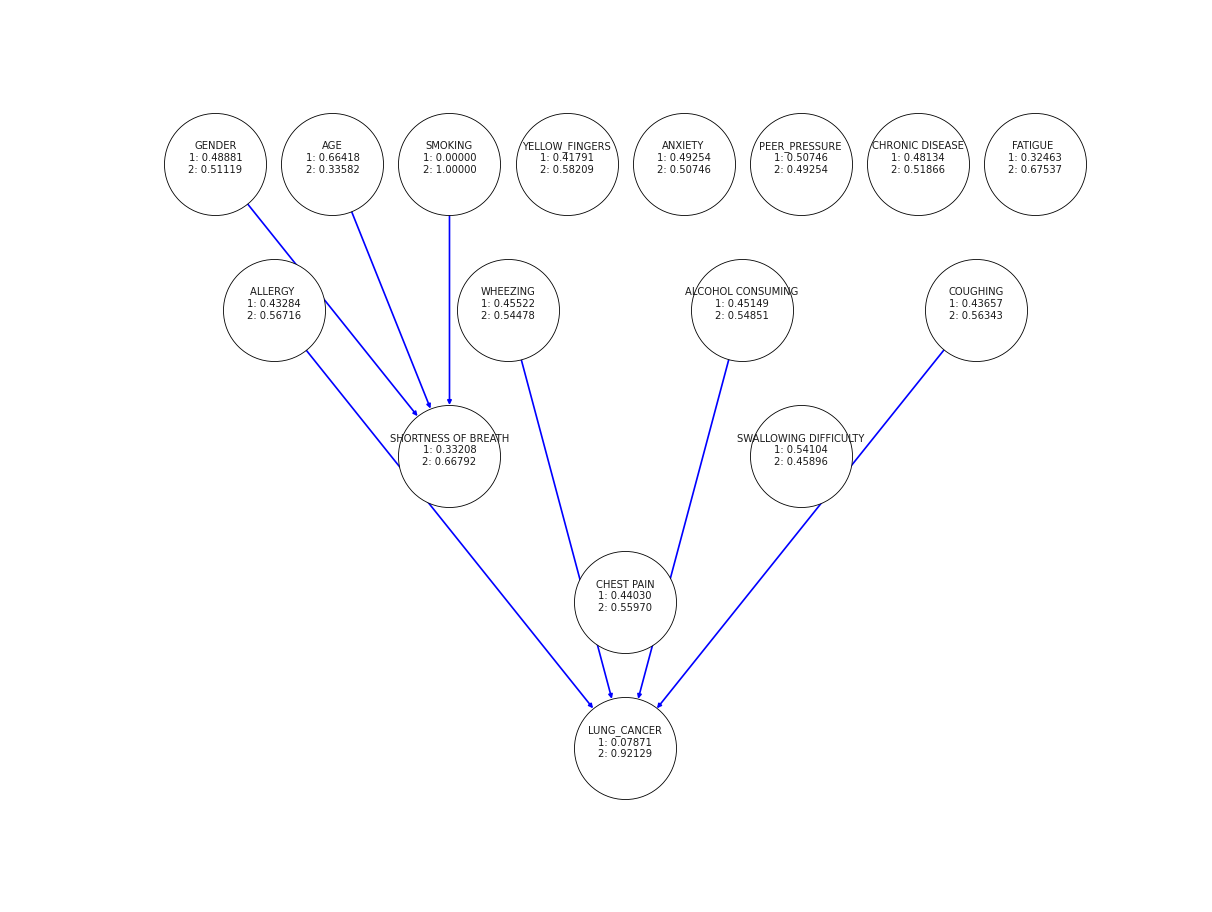

In [83]:
join_tree = InferenceController.apply(bbn)

# Use above function to add evidence
evidence(join_tree, 'SMOKING', 2, 1.0)

# Print marginal probabilities
draw_graph_probs(join_tree)

In [61]:
def test_prediction_for_one_item(bbn, df_item):
  jt = InferenceController.apply(bbn)

  for idx in range(len(df.columns)-1):
    evidence(jt, df.columns[idx], df_item[df.columns[idx]], 1.0)

  pred_dict = list(Potential.to_dict([jt.get_bbn_potential(jt.get_bbn_node_by_name('LUNG_CANCER'))]).values())
  pred = 2 if pred_dict[1] >= 0.86627 else 1

  real_value = df_item['LUNG_CANCER']

  return (pred==real_value), pred_dict, pred, real_value

In [62]:
def test_bbn_with_dataframe(bbn, df):
  test_count = df.shape[0]

  test_vals = []
  pred_vals = []

  correct_cnt = 0

  for i in range(test_count):
    df_item = df.iloc[i]
    isCorrect, probabilities, pred, real_value = test_prediction_for_one_item(bbn, df_item)
    if isCorrect and real_value == 1:
      print("XD")
    correct_cnt += 1 if isCorrect else 0
    test_vals.append(real_value)
    pred_vals.append(pred)
  
  return (correct_cnt/test_count), correct_cnt, test_count, test_vals, pred_vals

In [63]:
accuracy, correct_cnt, test_count, test_vals, pred_vals = test_bbn_with_dataframe(bbn, df_test)
print(f"Accuracy: {accuracy}")
print(f"Correct count: {correct_cnt}, All count: {test_count}")

XD
XD
XD
Accuracy: 0.6
Correct count: 24, All count: 40


# Porównanie do innych modeli

In [ ]:
X = df.drop(["LUNG_CANCER"], axis=1)
y = df["LUNG_CANCER"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42 )
print("X_train : ",len(X_train))
print("X_test : ",len(X_test))
print("y_train : ",len(y_train))
print("y_test : ",len(y_test))

X_train :  247
X_test :  62
y_train :  247
y_test :  62


### Regresja logiczna

In [ ]:
logreg = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=1000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
acc_log_train = round(logreg.score(X_train, y_train)*100,2)
acc_log_test = round(logreg.score(X_test,y_test)*100,2)
print("Training Accuracy: % {}".format(acc_log_train))
print("Test Accuracy: % {}".format(acc_log_test))

Training Accuracy: % 93.12
Test Accuracy: % 93.55


### Drzewo decezyjne

In [ ]:
dt = DecisionTreeClassifier(random_state = 42)
dt_param_grid = {"min_samples_split" : range(10,500,20),
                 "max_depth": range(1,20,2)
                }

clf = GridSearchCV(dt, param_grid=dt_param_grid, cv = StratifiedKFold(n_splits = 10), scoring = "accuracy", n_jobs = -1)
clf.fit(X_train,y_train)
y_pred_dt = clf.predict(X_test)
acc_dt_train = round(clf.score(X_train, y_train)*100,2) 
acc_dt_test = round(clf.score(X_test,y_test)*100,2) 
print("Training Accuracy: % {}".format(acc_dt_train))
print("Test Accuracy: % {}".format(acc_dt_test))

Training Accuracy: % 89.88
Test Accuracy: % 80.65


### SVC

In [ ]:
svc = SVC(random_state = 42)
svc_param_grid = {"kernel" : ["rbf"],
                 "gamma": [0.001, 0.01, 0.1, 1],
                 "C": [1,10,50,100,200,300,1000]
             }

clf = GridSearchCV(svc, param_grid=svc_param_grid, cv = StratifiedKFold(n_splits = 10), scoring = "accuracy", n_jobs = -1)
clf.fit(X_train,y_train)
y_pred_svc = clf.predict(X_test)
acc_svc_train = round(clf.score(X_train, y_train)*100,2) 
acc_svc_test = round(clf.score(X_test,y_test)*100,2) 
print("Training Accuracy: % {}".format(acc_svc_train))
print("Test Accuracy: % {}".format(acc_svc_test))


Training Accuracy: % 96.76
Test Accuracy: % 91.94


### Drzewo losowe

In [ ]:
rf = RandomForestClassifier(random_state = 42)
rf_param_grid = {"max_features": [1,3,10],
                "min_samples_split":[2,3,10],
                "min_samples_leaf":[1,3,10],
                "bootstrap":[False],
                "n_estimators":[100,300],
                "criterion":["gini"]
             }


clf = GridSearchCV(rf, param_grid=rf_param_grid, cv = StratifiedKFold(n_splits = 10), scoring = "accuracy", n_jobs = -1)
clf.fit(X_train,y_train)
y_pred_rf = clf.predict(X_test)
acc_rf_train = round(clf.score(X_train, y_train)*100,2)
acc_rf_test = round(clf.score(X_test,y_test)*100,2)
print("Training Accuracy: % {}".format(acc_rf_train))
print("Test Accuracy: % {}".format(acc_rf_test))

Training Accuracy: % 93.93
Test Accuracy: % 85.48


### Regresja logiczna

In [ ]:
lr = LogisticRegression(random_state = 42)
param_grid = {"C":np.logspace(-3,3,7),
                    "penalty": ["l1","l2"] 
             }  


clf = GridSearchCV(lr, param_grid=param_grid, cv = StratifiedKFold(n_splits = 10), scoring = "accuracy", n_jobs = -1)
clf.fit(X_train,y_train)
y_pred_lr = clf.predict(X_test)
acc_lr_train = round(clf.score(X_train, y_train)*100,2)
acc_lr_test = round(clf.score(X_test,y_test)*100,2) 
print("Training Accuracy: % {}".format(acc_lr_train))
print("Test Accuracy: % {}".format(acc_lr_test))

Training Accuracy: % 93.93
Test Accuracy: % 96.77


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
70 fits failed out of a total of 140.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Solve

In [ ]:
model = Sequential()

model.add(Dense(15, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dense(64, activation='softmax'))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_accuracy', mode='max',patience=5,restore_best_weights=False)

model.compile(optimizer='adam', loss="binary_crossentropy", metrics='accuracy')

history = model.fit(X_train,y_train,callbacks = [es],epochs=100,batch_size=1,validation_data = (X_test,y_test),shuffle=True)

Epoch 1/100
247/247 [==============================] - 2s 3ms/step - loss: 0.0620 - accuracy: 0.1215 - val_loss: -0.4062 - val_accuracy: 0.1290
Epoch 2/100
247/247 [==============================] - 0s 2ms/step - loss: -0.6913 - accuracy: 0.1255 - val_loss: -0.9508 - val_accuracy: 0.1290
Epoch 3/100
247/247 [==============================] - 0s 2ms/step - loss: -1.1972 - accuracy: 0.1255 - val_loss: -1.4264 - val_accuracy: 0.1290
Epoch 4/100
247/247 [==============================] - 0s 2ms/step - loss: -1.6507 - accuracy: 0.1255 - val_loss: -1.8594 - val_accuracy: 0.1290
Epoch 5/100
247/247 [==============================] - 0s 2ms/step - loss: -2.0740 - accuracy: 0.1255 - val_loss: -2.2711 - val_accuracy: 0.1290
Epoch 6/100
247/247 [==============================] - 0s 2ms/step - loss: -2.4801 - accuracy: 0.1255 - val_loss: -2.6691 - val_accuracy: 0.1290
